Import libaries

In [1]:
import pickle
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import os
import logging
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.callbacks import EarlyStopping


2024-10-13 04:28:45.199493: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-13 04:28:45.507096: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-13 04:28:46.369368: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Data Loading

In [2]:
#GPU check
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-10-13 04:28:49.064685: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 04:28:49.208509: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 04:28:49.208563: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
def load_data(file_path):
    with open(file_path, 'rb') as file:
        dataset = pickle.load(file)
    return dataset['data'], dataset['labels']

data_path = 'EMNIST_Byclass_Small/'
X_train, y_train = load_data(data_path+'emnist_train.pkl')
X_test, y_test = load_data(data_path+'emnist_test.pkl')
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_train data type:", X_train.dtype)
print("y_train data type:", y_train.dtype)

X_train shape: (100000, 28, 28)
y_train shape: (100000,)
X_train data type: uint8
y_train data type: int64


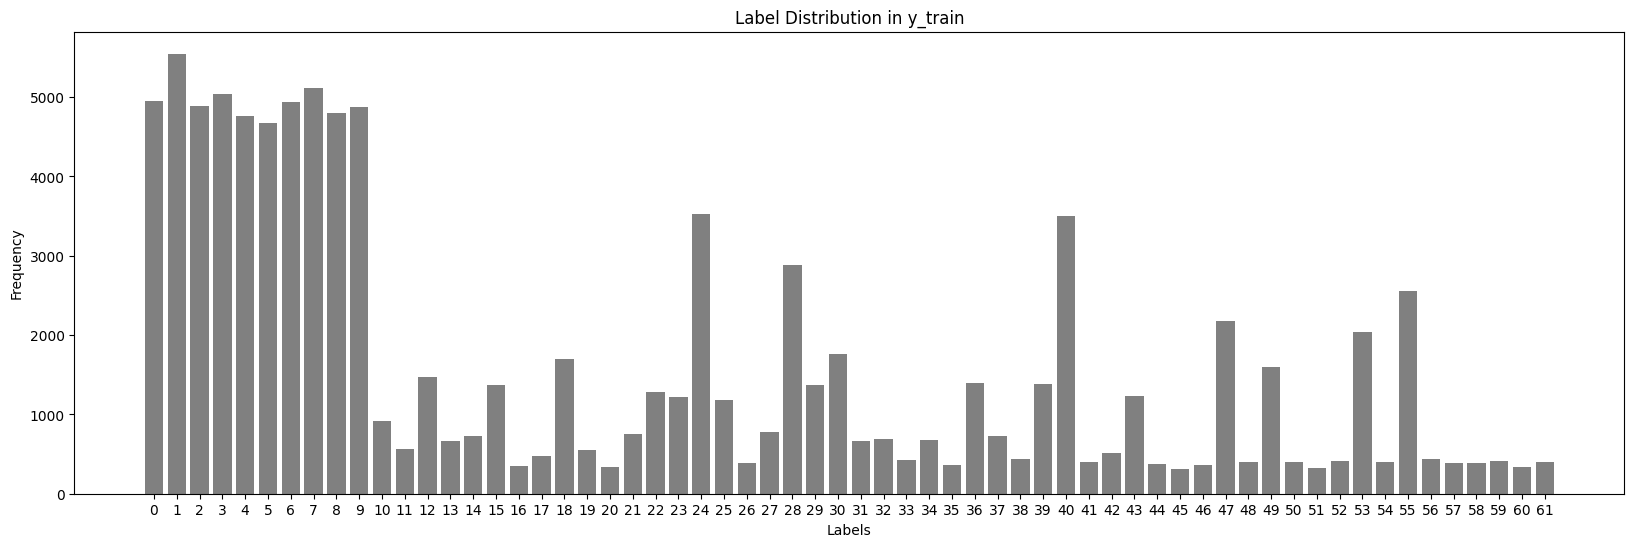

In [4]:
unique, counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(20, 6))
plt.bar(unique, counts, color='gray')
plt.title('Label Distribution in y_train')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(unique)
plt.show()

Outliers

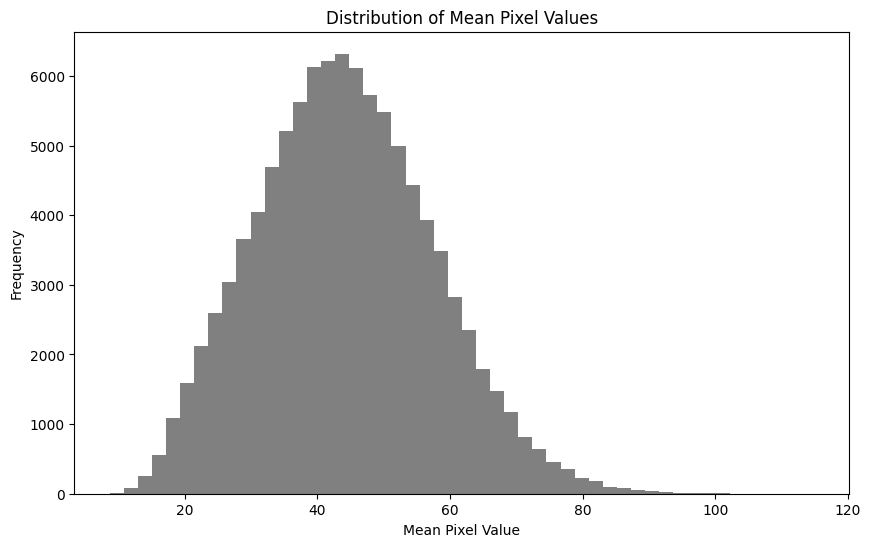

In [5]:
mean_pixel_values = np.mean(X_train, axis=(1, 2))
plt.figure(figsize=(10, 6))
plt.hist(mean_pixel_values, bins=50, color='gray')
plt.title('Distribution of Mean Pixel Values')
plt.xlabel('Mean Pixel Value')
plt.ylabel('Frequency')
plt.show()

Intensity

In [6]:
print("Min pixel value:", np.min(X_train))
print("Max pixel value:", np.max(X_train))
print("Mean pixel value:", np.mean(X_train))
print("Std pixel value:", np.std(X_train))

Min pixel value: 0
Max pixel value: 255
Mean pixel value: 44.199759910714285
Std pixel value: 84.52433433555304


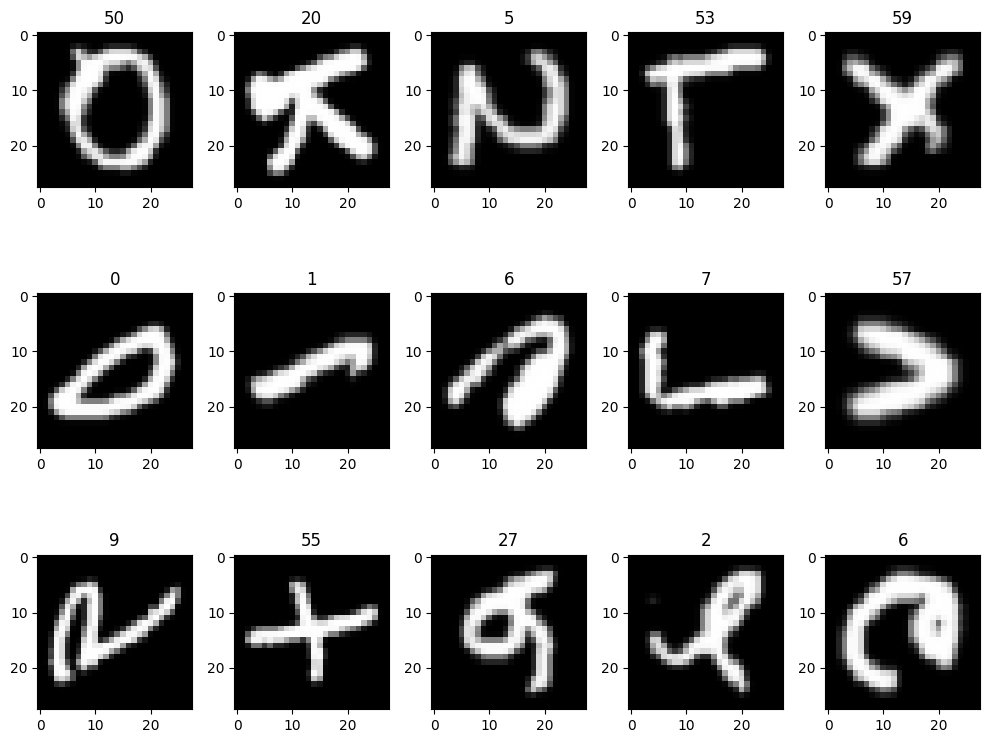

In [7]:
fig, axes = plt.subplots(3, 5, figsize=(10, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape([28, 28]), cmap='gray')
    ax.set_title(y_train[i])
plt.tight_layout()
plt.show()

In [8]:
#data normalised to 0 - 1
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

num_classes = 62
#Change the labels to one hot for classification
train_labels = to_categorical(y_train, num_classes)
test_labels = to_categorical(y_test, num_classes)

print(f"Training data shape: {X_train.shape}, Training labels shape: {train_labels.shape}")
print(f"Test data shape: {y_test.shape}, Test labels shape: {test_labels.shape}")

Training data shape: (100000, 28, 28, 1), Training labels shape: (100000, 62)
Test data shape: (20000,), Test labels shape: (20000, 62)


In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Data augmentation for the training data
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
#No augmentation data generator
train_datagenn_no_aug = ImageDataGenerator()
# No augmentation for the validation data, just rescaling
val_datagen = ImageDataGenerator()

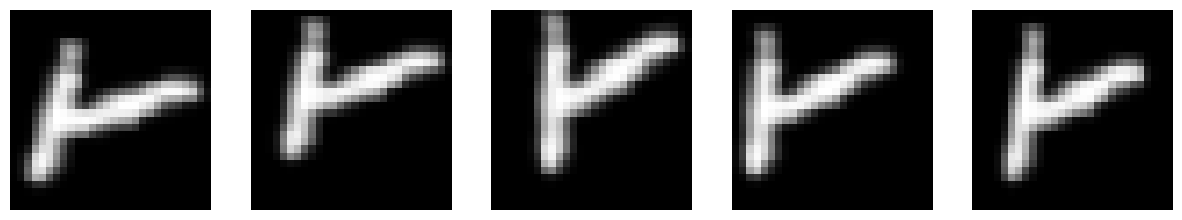

In [10]:
sample_image = X_train[0].reshape((1, 28, 28, 1))
augmented_images = train_datagen.flow(sample_image, batch_size=1)

# Plot several augmented versions of the same image
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    # Generate augmented image
    aug_image = augmented_images.__next__()[0].reshape(28, 28)

    # Display the augmented image
    axes[i].imshow(aug_image, cmap='gray')
    axes[i].axis('off')

plt.show()

In [11]:
#Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

In [12]:
#set up base parameters
epochs = 30
batch_size = 32
loss="sparse_categorical_crossentropy"
#loss="categorical_crossentropy"
input_shape = (28, 28, 1)
num_classes = 62
hyperparameters = {
    'hidden_size' : 64,
    'dropout_rate' : 0.3,
    'learning_rate' : 1e-3,
    'regularization_rate' : 0.0,
    #Have activation and output activation functions in hyperparameter incase they should be tuned
    'activation' : 'relu',
    'output_activation' : 'softmax'
}

In [13]:
#Flow the generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
train_generator_no_aug = train_datagenn_no_aug.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

Residual Network Builder

In [14]:

def se_block(inputs, reduction_ratio=16):
    #Self attention
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)
    se = layers.Dense(filters // reduction_ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape([1, 1, filters])(se)
    return layers.Multiply()([inputs, se])

def residual_block(inputs, filters, kernel_size=4, stride=1, dropout_rate=0.3, activation='relu', use_se=True):
    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add attention (Squeeze-and-Excitation block) if specified
    if use_se:
        x = se_block(x)

    # Adjust inputs if necessary (to match dimensions)
    if stride != 1 or inputs.shape[-1] != filters:
        inputs = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
        inputs = layers.BatchNormalization()(inputs)

    # Dropout before residual addition
    x = layers.Dropout(dropout_rate)(x)

    # Residual connection
    x = layers.Add()([x, inputs])
    x = layers.Activation(activation)(x)

    return x

def build_resnet(input_shape, num_classes, hyperparameters):
    inputs = layers.Input(shape=input_shape)
    dropout_rate = hyperparameters['dropout_rate']
    hidden_size = hyperparameters['hidden_size']
    activation= hyperparameters['activation']
    regularization_rate = hyperparameters['regularization_rate']
    # Initial convolution layer
    x = layers.Conv2D(hidden_size, (4, 4), padding='same', strides=1)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)

    # Residual blocks
    x = residual_block(x, hidden_size, dropout_rate=dropout_rate, activation=activation)
    x = residual_block(x, hidden_size*2, stride=2, dropout_rate=dropout_rate, activation=activation)
    x = residual_block(x, hidden_size*4, stride=2, dropout_rate=dropout_rate, activation=activation)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(hidden_size*8, activation=activation,
                    kernel_regularizer=regularizers.l2(regularization_rate))(x)
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'],
                        kernel_regularizer=regularizers.l2(regularization_rate))(x)

    model = models.Model(inputs, outputs)

    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

In [15]:
def build_vggnet(input_shape, num_classes, hp, num_conv_blocks=5):
    dropout_rate = hyperparameters['dropout_rate']
    hidden_size = int(hyperparameters['hidden_size'] / 2)  # Used for Dense layers
    activation = hyperparameters['activation']

    inputs = layers.Input(shape=input_shape)

    # VGG blocks
    x = inputs
    current_height, current_width = input_shape[:2]  # Get spatial dimensions

    for block in range(num_conv_blocks):
        # Add 2 or 3 Conv layers depending on the block
        num_conv_layers = 2 if block < 3 else 3
        for _ in range(num_conv_layers):
            x = layers.Conv2D(int(hidden_size), (4, 4), padding='same')(x)  # Convert hidden_size to int
            x = layers.BatchNormalization()(x)
            x = layers.Activation(activation)(x)

        # Check spatial dimensions before applying MaxPooling
        if current_height > 1 and current_width > 1:
            x = layers.MaxPooling2D(pool_size=(2, 2), strides=2)(x)
            current_height //= 2
            current_width //= 2
        else:
            break  # Avoid further downscaling if spatial dimensions are too small

        # Double filter size after each block
        hidden_size *= 2

    # Flatten and Dense layers
    x = layers.Flatten()(x)
    x = layers.Dense(int(hidden_size * 4), activation=activation)(x)  # Convert hidden_size to int
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(int(hidden_size * 4), activation=activation)(x)  # Convert hidden_size to int
    x = layers.Dropout(dropout_rate)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'],
                        kernel_regularizer=regularizers.l2(hyperparameters['regularization_rate']))(x)
    model = models.Model(inputs, outputs)

    optimizer = Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])  # 'loss' added to hyperparameters

    return model

In [16]:
def build_mlp(input_shape, num_classes, hidden_size):
    hidden_size = hyperparameters['hidden_size']
    dropout_rate = hyperparameters['dropout_rate']
    activation= hyperparameters['activation']
    inputs = layers.Input(shape=input_shape)

    # Flatten the input (28, 28, 1) -> (784,)
    x = layers.Flatten(input_shape=input_shape)(inputs)

    x = layers.Dense(hidden_size*8)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(hidden_size*4)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(hidden_size*2)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Dropout(dropout_rate+0.1)(x)

    outputs = layers.Dense(num_classes, activation=hyperparameters['output_activation'],
                        kernel_regularizer=regularizers.l2(hyperparameters['regularization_rate']))(x)

    model = models.Model(inputs, outputs)

    optimizer=Adam(learning_rate=hyperparameters['learning_rate'])
    model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    return model

In [17]:
model_resnet = build_resnet(input_shape, num_classes, hyperparameters)
model_resnet.summary()

2024-10-13 04:28:50.654236: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 04:28:50.654313: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 04:28:50.654347: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 04:28:51.031282: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-13 04:28:51.031346: I external/local_xla/xla/stream_executor

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │      1,088 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     65,600 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 28, 28,    │          0 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     65,600 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 4)         │        260 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │        320 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 28, 28,    │          0 │ multiply[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 28, 28,    │          0 │ dropout_1[0][0],  │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 28, 28,    │          0 │ add[0][0]       

 Total params: 2,320,474 (8.85 MB)

 Trainable params: 2,317,786 (8.84 MB)

 Non-trainable params: 2,688 (10.50 KB)

In [18]:
model_vggnet = build_vggnet(input_shape, num_classes, hyperparameters)
model_vggnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 32)     │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 32)     │        16,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 64)     │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 7, 7, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             

 Total params: 19,003,390 (72.49 MB)

 Trainable params: 18,997,886 (72.47 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [19]:
model_mlp = build_mlp(input_shape, num_classes, hyperparameters)
model_mlp.summary()

/home/epsilon/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_20 (Activation)      │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_21 (Activation)      │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 62)             │         7,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 577,726 (2.20 MB)

 Trainable params: 575,934 (2.20 MB)

 Non-trainable params: 1,792 (7.00 KB)

Hyperparameter tuning

In [20]:
def plot_model_accuracies(model_groups):
    for group_name, models in model_groups.items():
        plt.figure(figsize=(8, 6))

        # Loop over each model in the group
        for i, (model_name, (model, history)) in enumerate(models.items()):

            # Access the history attribute to get training metrics
            history_data = history.history

            # Plot training and validation accuracy
            plt.plot(history_data['accuracy'], label=f'{model_name} training Accuracy')
            plt.plot(history_data['val_accuracy'], label=f'{model_name} validation Accuracy')

        # Display the plot

        plt.title(f"Performance of Models in {group_name}")
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        plt.show()


In [21]:
def single_hyperparameter_tuner(parameter, values):
    epochs = 20
    hyperparameters = {
    'hidden_size' : 64,
    'dropout_rate' : 0.3,
    'learning_rate' : 1e-3,
    'regularization_rate' : 0.0,
    'activation' : 'relu',
    'output_activation' : 'softmax'
    }
    # Initiate results to be return in a dictionary of dictionary (groups of models)
    res = {
        'resnet' : {},
        'vggnet' : {},
        'mlp' : {}
    }

    for val in values:
        hyperparameters[parameter] = val
        model = build_resnet(input_shape, num_classes, hyperparameters)
        history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)
        res['resnet']['resnet_'+parameter+'_'+str(val)] = (model, history)

        model = build_vggnet(input_shape, num_classes, hyperparameters)
        history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)
        res['vggnet']['vggnet_'+parameter+'_'+str(val)] = (model, history)

        model = build_mlp(input_shape, num_classes, hyperparameters)
        history = model.fit(train_generator,
          epochs=epochs,
          validation_data=val_generator)
        res['mlp']['mlp_'+parameter+'_'+str(val)] = (model, history)

    return res

In [22]:
hidden_test = single_hyperparameter_tuner('hidden_size', [16, 32, 64])

Epoch 1/20


/home/epsilon/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728754134.784076  226390 service.cc:145] XLA service 0x7ff5f8014d90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728754134.784116  226390 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-10-13 04:28:54.886323: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-13 04:28:55.309439: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


   9/2500 ━━━━━━━━━━━━━━━━━━━━ 52s 21ms/step - accuracy: 0.0366 - loss: 4.1463    

I0000 00:00:1728754144.167122  226390 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - accuracy: 0.4645 - loss: 2.0185 - val_accuracy: 0.8004 - val_loss: 0.5885
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7555 - loss: 0.7509 - val_accuracy: 0.7976 - val_loss: 0.5793
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7858 - loss: 0.6384 - val_accuracy: 0.8314 - val_loss: 0.4772
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.7999 - loss: 0.5894 - val_accuracy: 0.8359 - val_loss: 0.4613
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.8098 - loss: 0.5540 - val_accuracy: 0.8345 - val_loss: 0.4616
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8145 - loss: 0.5402 - val_accuracy: 0.8346 - val_loss: 0.4507
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8182 - loss: 0.5209 - val_accuracy: 0.8453 - val_loss: 0.4290
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8235 - loss: 0.5060 - val

I0000 00:00:1728754425.374650  229366 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 24 bytes spill stores, 24 bytes spill loads

I0000 00:00:1728754425.388377  229364 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1728754425.739709  229364 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4268', 8 bytes spill stores, 8 bytes spill loads



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5464 - loss: 1.6589

I0000 00:00:1728754451.321454  229666 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_374', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1728754451.371696  229657 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_374', 368 bytes spill stores, 368 bytes spill loads

I0000 00:00:1728754451.587465  229660 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_357', 192 bytes spill stores, 192 bytes spill loads



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.5464 - loss: 1.6587 - val_accuracy: 0.6933 - val_loss: 1.0302
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - accuracy: 0.7379 - loss: 0.8305 - val_accuracy: 0.7539 - val_loss: 0.7277
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7678 - loss: 0.7120 - val_accuracy: 0.7802 - val_loss: 0.6640
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7897 - loss: 0.6360 - val_accuracy: 0.8076 - val_loss: 0.5664
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8001 - loss: 0.5914 - val_accuracy: 0.8282 - val_loss: 0.4628
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8088 - loss: 0.5621 - val_accuracy: 0.8196 - val_loss: 0.5157
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8188 - loss: 0.5293 - val_accuracy: 0.8344 - val_loss: 0.4707
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8243 - loss: 0.5125 - val

I0000 00:00:1728755107.498285  235756 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1728755107.741835  235765 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5889', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728755107.802498  235759 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 40 bytes spill stores, 40 bytes spill loads



2493/2500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5453 - loss: 1.6761

I0000 00:00:1728755128.352382  236082 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_443', 8 bytes spill stores, 8 bytes spill loads



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - accuracy: 0.5458 - loss: 1.6742 - val_accuracy: 0.7798 - val_loss: 0.6710
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.7913 - loss: 0.6117 - val_accuracy: 0.8271 - val_loss: 0.4661
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8125 - loss: 0.5420 - val_accuracy: 0.8400 - val_loss: 0.4458
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8231 - loss: 0.5000 - val_accuracy: 0.8396 - val_loss: 0.4453
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8283 - loss: 0.4773 - val_accuracy: 0.8320 - val_loss: 0.4671
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8349 - loss: 0.4640 - val_accuracy: 0.8439 - val_loss: 0.4428
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 15s 6ms/step - accuracy: 0.8387 - loss: 0.4536 - val_accuracy: 0.8460 - val_loss: 0.4260
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.8418 - loss: 0.4344 - val

I0000 00:00:1728756130.809492  245255 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 4 bytes spill stores, 4 bytes spill loads

I0000 00:00:1728756130.827127  245247 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5889', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728756130.840037  245253 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1728756131.271822  245244 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 32 bytes spill stores, 32 bytes spill loads



2500/2500 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.5821 - loss: 1.5129 - val_accuracy: 0.8126 - val_loss: 0.5370
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8055 - loss: 0.5596 - val_accuracy: 0.8251 - val_loss: 0.4943
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8229 - loss: 0.5014 - val_accuracy: 0.8368 - val_loss: 0.4506
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8319 - loss: 0.4702 - val_accuracy: 0.8469 - val_loss: 0.4204
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8386 - loss: 0.4452 - val_accuracy: 0.8471 - val_loss: 0.4278
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8429 - loss: 0.4266 - val_accuracy: 0.8441 - val_loss: 0.4422
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8460 - loss: 0.4184 - val_accuracy: 0.8436 - val_loss: 0.4250
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8519 - loss: 0.4014 - va

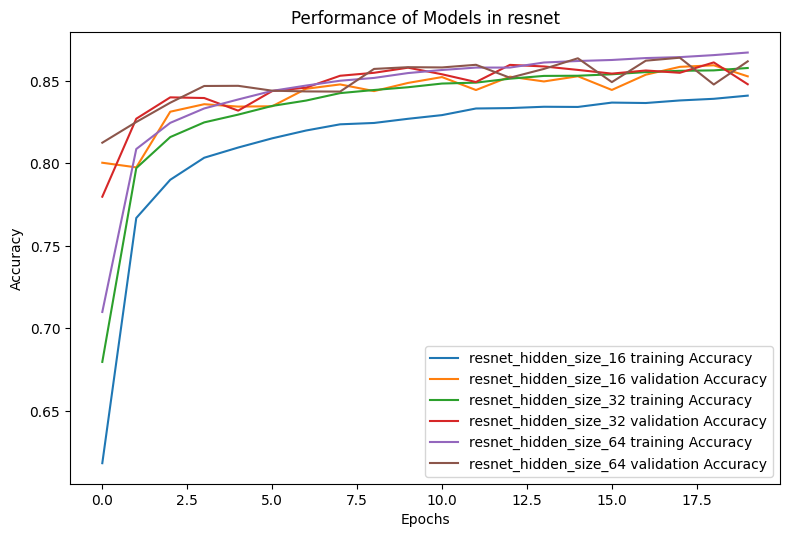

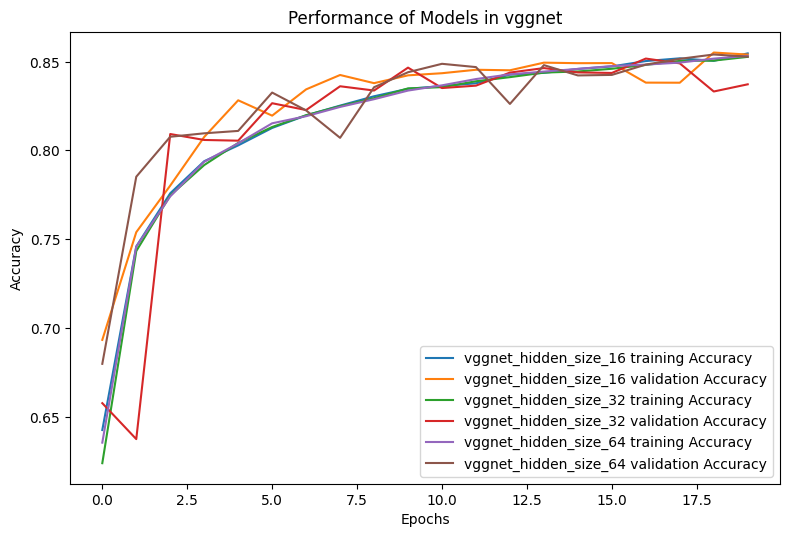

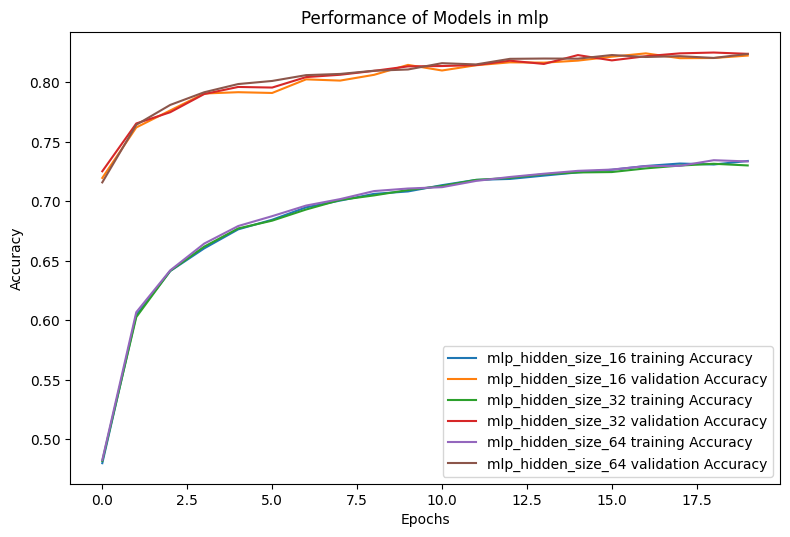

In [23]:
plot_model_accuracies(hidden_test)


In [24]:
dropout_test = single_hyperparameter_tuner('dropout_rate', [0.1, 0.2, 0.3, 0.4])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.6414 - loss: 1.2670 - val_accuracy: 0.8161 - val_loss: 0.5061
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8166 - loss: 0.5153 - val_accuracy: 0.8201 - val_loss: 0.5135
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8369 - loss: 0.4498 - val_accuracy: 0.8365 - val_loss: 0.4484
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8432 - loss: 0.4251 - val_accuracy: 0.8342 - val_loss: 0.4465
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8463 - loss: 0.4129 - val_accuracy: 0.8201 - val_loss: 0.5298
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8539 - loss: 0.3933 - val_accuracy: 0.8397 - val_loss: 0.4401
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8578 - loss: 0.3772 - val_accuracy: 0.8439 - val_loss: 0.4493
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8597 - loss: 0

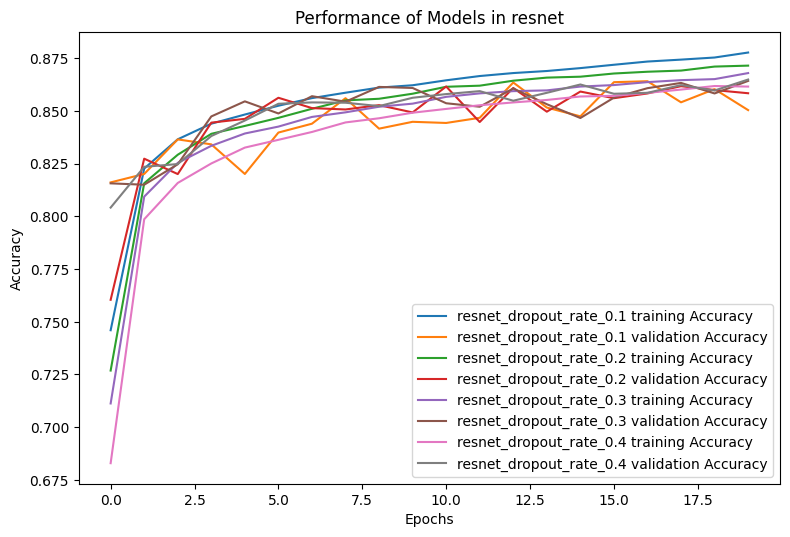

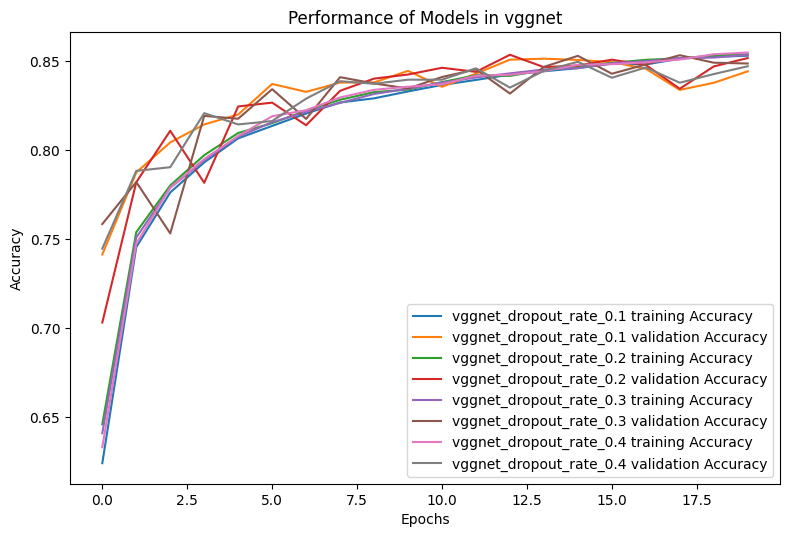

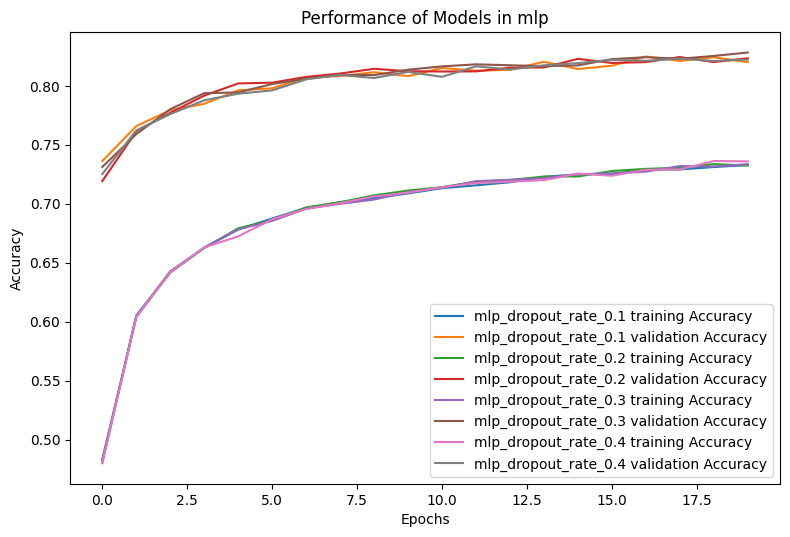

In [25]:
plot_model_accuracies(dropout_test)

In [26]:
lr_test = single_hyperparameter_tuner('learning_rate', [1e-2, 1e-3, 1e-4])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.4308 - loss: 2.0967 - val_accuracy: 0.7781 - val_loss: 0.6849
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7384 - loss: 0.8027 - val_accuracy: 0.8056 - val_loss: 0.5620
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7706 - loss: 0.6926 - val_accuracy: 0.8193 - val_loss: 0.5218
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.7870 - loss: 0.6494 - val_accuracy: 0.8365 - val_loss: 0.4692
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8003 - loss: 0.6001 - val_accuracy: 0.8359 - val_loss: 0.4698
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8071 - loss: 0.5708 - val_accuracy: 0.8383 - val_loss: 0.4510
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8094 - loss: 0.5574 - val_accuracy: 0.8411 - val_loss: 0.4405
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8162 - loss: 0

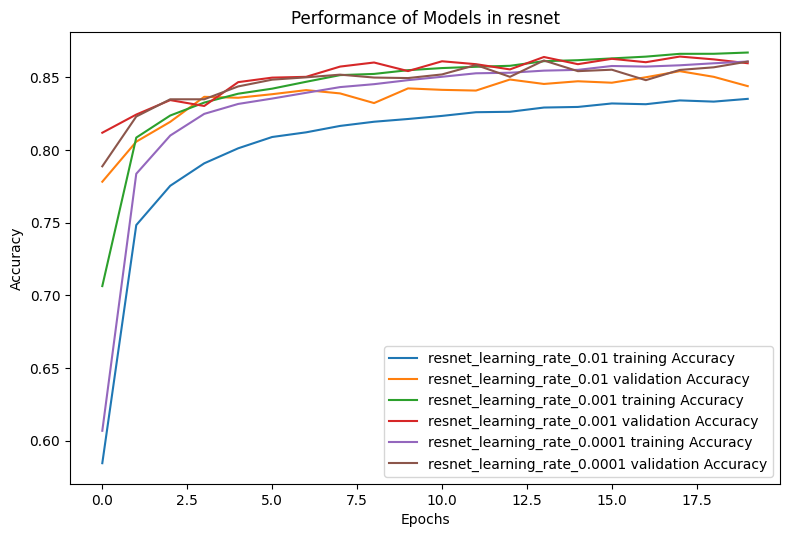

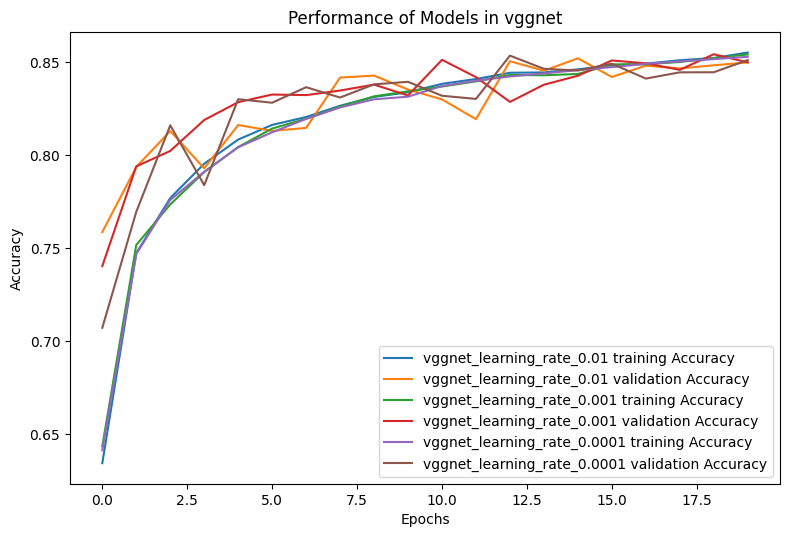

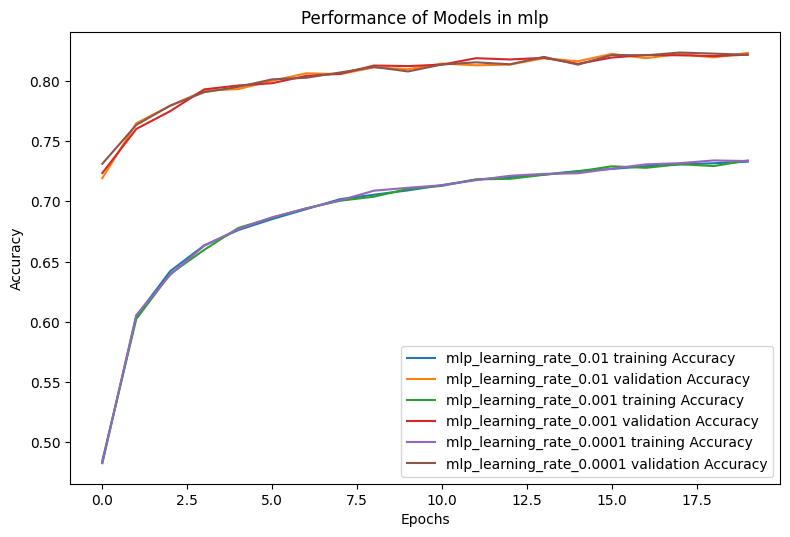

In [27]:
plot_model_accuracies(lr_test)

In [28]:
regularization_test = single_hyperparameter_tuner('regularization_rate', [0.0, 0.01, 0.03])

Epoch 1/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 33s 9ms/step - accuracy: 0.5866 - loss: 1.5067 - val_accuracy: 0.8073 - val_loss: 0.5777
Epoch 2/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8017 - loss: 0.5695 - val_accuracy: 0.8270 - val_loss: 0.4898
Epoch 3/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8204 - loss: 0.5034 - val_accuracy: 0.8438 - val_loss: 0.4409
Epoch 4/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8281 - loss: 0.4786 - val_accuracy: 0.8395 - val_loss: 0.4611
Epoch 5/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8363 - loss: 0.4545 - val_accuracy: 0.8513 - val_loss: 0.4126
Epoch 6/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8407 - loss: 0.4355 - val_accuracy: 0.8457 - val_loss: 0.4515
Epoch 7/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8468 - loss: 0.4231 - val_accuracy: 0.8557 - val_loss: 0.3922
Epoch 8/20
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8521 - loss: 0

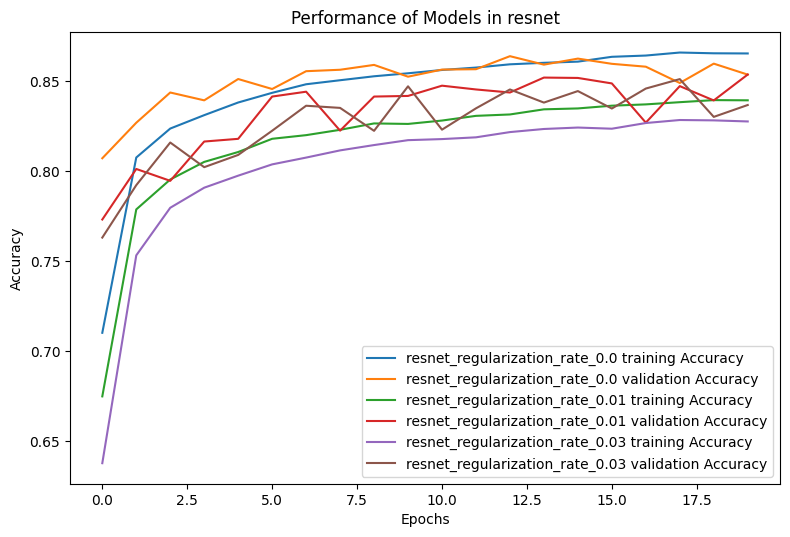

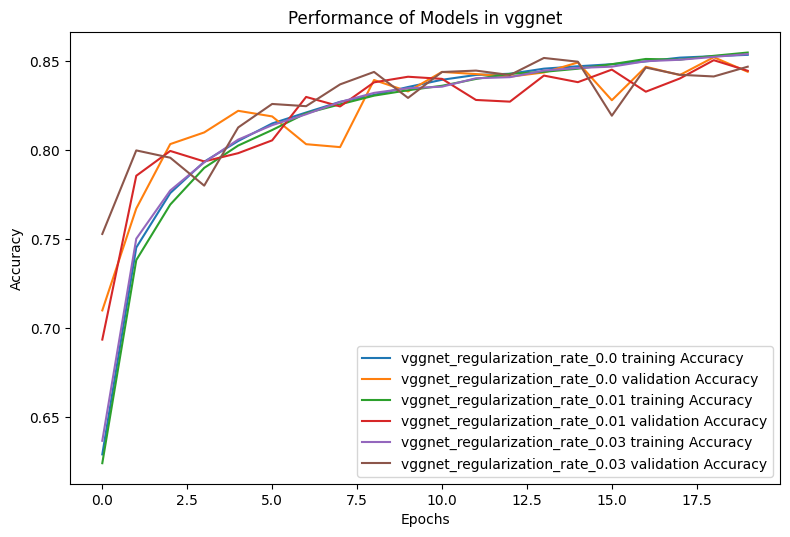

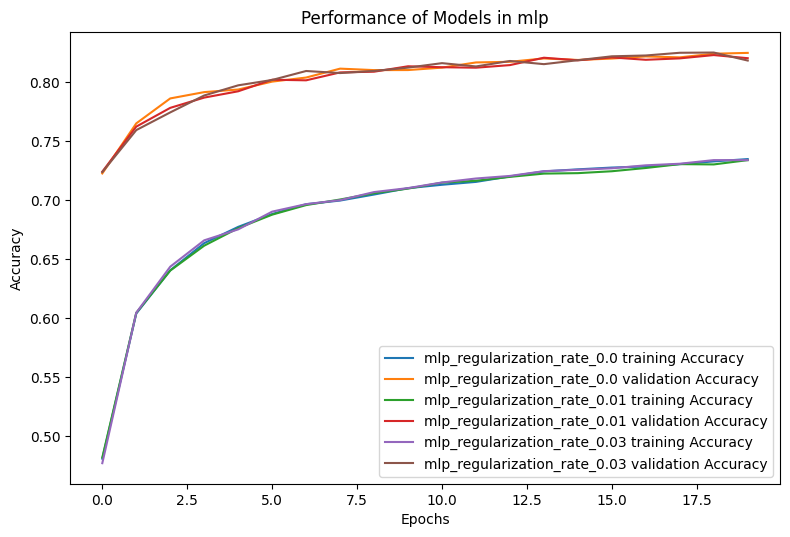

In [29]:
plot_model_accuracies(regularization_test)

In [30]:
# Batch tests requires data to be flowed again and cant use the tuner function
batch_test = {
    'resnet' : {},
    'vggnet' : {},
    'mlp' : {}
}
for bs in [16, 32, 64, 128]:
    train_generator = train_datagen.flow(X_train, y_train, batch_size=bs)

    # Create nested dictionaries if they don't exist
    model = build_resnet(input_shape, num_classes, hyperparameters)
    history = model.fit(train_generator,
        epochs=epochs,
        validation_data=val_generator)
    batch_test['resnet']['resnet_batch_'+str(bs)] = (model, history)

    model = build_vggnet(input_shape, num_classes, hyperparameters)
    history = model.fit(train_generator,
        epochs=epochs,
        validation_data=val_generator)
    batch_test['vggnet']['vggnet_batch_'+str(bs)] = (model, history)

    model = build_mlp(input_shape, num_classes, hyperparameters)
    history = model.fit(train_generator,
        epochs=epochs,
        validation_data=val_generator)
    batch_test['mlp']['mlp_batch_'+str(bs)] = (model, history)

Epoch 1/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 44s 6ms/step - accuracy: 0.5840 - loss: 1.4932 - val_accuracy: 0.7871 - val_loss: 0.6271
Epoch 2/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8004 - loss: 0.5807 - val_accuracy: 0.8314 - val_loss: 0.4865
Epoch 3/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8181 - loss: 0.5087 - val_accuracy: 0.8392 - val_loss: 0.4555
Epoch 4/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8314 - loss: 0.4728 - val_accuracy: 0.8505 - val_loss: 0.4204
Epoch 5/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8380 - loss: 0.4472 - val_accuracy: 0.8479 - val_loss: 0.4321
Epoch 6/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8449 - loss: 0.4275 - val_accuracy: 0.8539 - val_loss: 0.4011
Epoch 7/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8469 - loss: 0.4163 - val_accuracy: 0.8357 - val_loss: 0.4644
Epoch 8/30
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 30s 6ms/step - accuracy: 0.8500 - loss: 0

I0000 00:00:1728773028.016106  389925 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 428 bytes spill stores, 428 bytes spill loads

I0000 00:00:1728773028.167959  389916 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 492 bytes spill stores, 492 bytes spill loads

I0000 00:00:1728773028.189024  389915 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5822', 448 bytes spill stores, 408 bytes spill loads



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 35s 15ms/step - accuracy: 0.5715 - loss: 1.5827 - val_accuracy: 0.8022 - val_loss: 0.5600
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8059 - loss: 0.5601 - val_accuracy: 0.8181 - val_loss: 0.5177
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8230 - loss: 0.4963 - val_accuracy: 0.8426 - val_loss: 0.4555
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8311 - loss: 0.4643 - val_accuracy: 0.8389 - val_loss: 0.4484
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8403 - loss: 0.4459 - val_accuracy: 0.8438 - val_loss: 0.4546
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8408 - loss: 0.4318 - val_accuracy: 0.8492 - val_loss: 0.4157
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8461 - loss: 0.4178 - val_accuracy: 0.8515 - val_loss: 0.3983
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 18s 15ms/step - accuracy: 0.8504 - loss: 0.40

I0000 00:00:1728773592.147952  392973 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 372 bytes spill stores, 372 bytes spill loads

I0000 00:00:1728773592.218115  392970 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 360 bytes spill stores, 360 bytes spill loads

I0000 00:00:1728773592.383508  392975 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4201', 448 bytes spill stores, 408 bytes spill loads



1250/1250 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.5649 - loss: 1.5428 - val_accuracy: 0.4775 - val_loss: 2.1631
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7656 - loss: 0.7227 - val_accuracy: 0.7983 - val_loss: 0.6266
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.7888 - loss: 0.6369 - val_accuracy: 0.7768 - val_loss: 0.7121
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8067 - loss: 0.5727 - val_accuracy: 0.7681 - val_loss: 0.6945
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8156 - loss: 0.5442 - val_accuracy: 0.7832 - val_loss: 0.5955
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8178 - loss: 0.5269 - val_accuracy: 0.8317 - val_loss: 0.4825
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - accuracy: 0.8255 - loss: 0.5086 - val_accuracy: 0.8282 - val_loss: 0.4704
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.8316 - loss: 0.48

I0000 00:00:1728774348.441079  397551 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_7267', 12 bytes spill stores, 12 bytes spill loads

I0000 00:00:1728774349.419815  397555 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6146', 284 bytes spill stores, 268 bytes spill loads

I0000 00:00:1728774349.461368  397562 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 32 bytes spill stores, 40 bytes spill loads

I0000 00:00:1728774349.532304  397556 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_5822', 88 bytes spill stores, 92 bytes spill loads

I0000 00:00:1728774349.680536  397552 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6148', 12 bytes spill stores, 20 bytes spill loads

I0000 00:00:1728774349.75740

625/625 ━━━━━━━━━━━━━━━━━━━━ 34s 26ms/step - accuracy: 0.5352 - loss: 1.7402 - val_accuracy: 0.7595 - val_loss: 0.7184
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8085 - loss: 0.5577 - val_accuracy: 0.8225 - val_loss: 0.5144
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8263 - loss: 0.4883 - val_accuracy: 0.8353 - val_loss: 0.4630
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8332 - loss: 0.4622 - val_accuracy: 0.8423 - val_loss: 0.4399
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8423 - loss: 0.4367 - val_accuracy: 0.8163 - val_loss: 0.5290
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8481 - loss: 0.4186 - val_accuracy: 0.8436 - val_loss: 0.4396
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8484 - loss: 0.4150 - val_accuracy: 0.8525 - val_loss: 0.4174
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8497 - loss: 0.4058 - val_accurac

I0000 00:00:1728774842.240757  400439 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4201', 448 bytes spill stores, 408 bytes spill loads

I0000 00:00:1728774842.292031  400440 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_4201', 88 bytes spill stores, 92 bytes spill loads

I0000 00:00:1728774842.341116  400432 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3413', 148 bytes spill stores, 116 bytes spill loads

I0000 00:00:1728774842.488403  400438 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1728774842.543661  400442 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_6513', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1728774842.79511

625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 20ms/step - accuracy: 0.5914 - loss: 1.4613 - val_accuracy: 0.7337 - val_loss: 0.9153
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.7858 - loss: 0.6477 - val_accuracy: 0.7696 - val_loss: 0.7103
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8078 - loss: 0.5669 - val_accuracy: 0.7883 - val_loss: 0.6304
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8135 - loss: 0.5441 - val_accuracy: 0.8116 - val_loss: 0.5789
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - accuracy: 0.8271 - loss: 0.5043 - val_accuracy: 0.8138 - val_loss: 0.5619
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.8294 - loss: 0.4919 - val_accuracy: 0.7591 - val_loss: 0.6811
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8327 - loss: 0.4773 - val_accuracy: 0.8260 - val_loss: 0.5098
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.8370 - loss: 0.4653 - val_accurac

I0000 00:00:1728775207.373995  402742 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1735', 88 bytes spill stores, 92 bytes spill loads

I0000 00:00:1728775207.549552  402733 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_1735', 160 bytes spill stores, 156 bytes spill loads



625/625 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - accuracy: 0.3546 - loss: 2.6480 - val_accuracy: 0.7097 - val_loss: 0.9624
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5945 - loss: 1.4177 - val_accuracy: 0.7538 - val_loss: 0.7452
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6483 - loss: 1.1753 - val_accuracy: 0.7733 - val_loss: 0.6652
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.6711 - loss: 1.0695 - val_accuracy: 0.7839 - val_loss: 0.6256
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6959 - loss: 0.9854 - val_accuracy: 0.7972 - val_loss: 0.5835
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7045 - loss: 0.9423 - val_accuracy: 0.7968 - val_loss: 0.5703
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.7154 - loss: 0.9009 - val_accuracy: 0.8051 - val_loss: 0.5472
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7215 - loss: 0.8716 - val_accurac

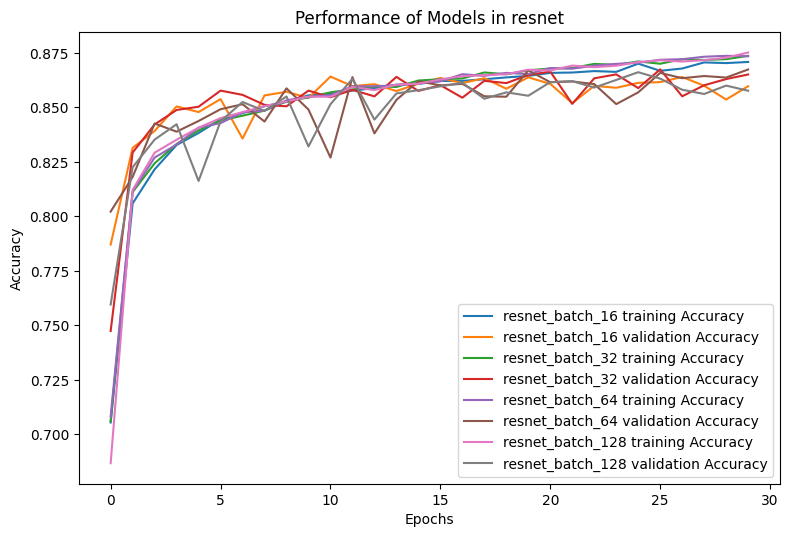

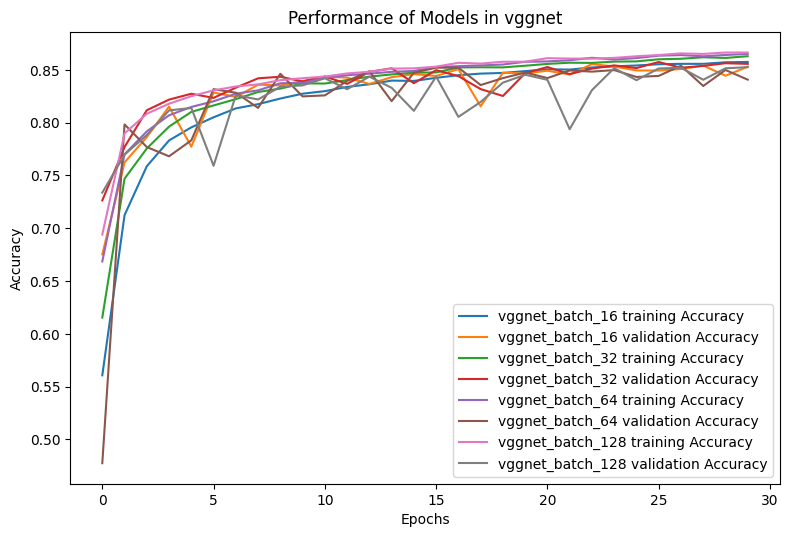

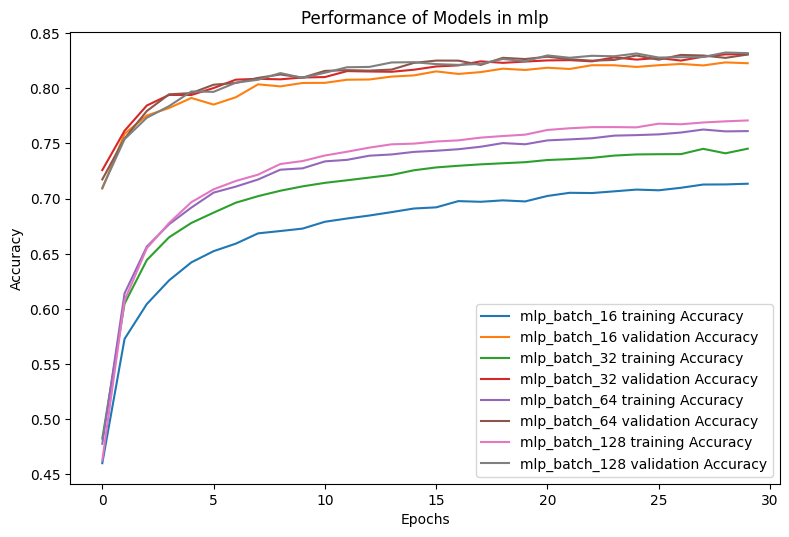

In [31]:
plot_model_accuracies(batch_test)

In [32]:
# augmentation tests requires differnt data generators and cant use the tuner function natively
augmentation_test = {
    'resnet' : {},
    'vggnet' : {},
    'mlp' : {}
}
for data_gen, name in [(train_generator, 'aug'), (train_generator_no_aug, 'no_aug')]:

    model = build_resnet(input_shape, num_classes, hyperparameters)
    history = model.fit(data_gen,
        epochs=epochs,
        validation_data=val_generator)
    augmentation_test['resnet']['resnet_'+name] = (model, history)

    model = build_vggnet(input_shape, num_classes, hyperparameters)
    history = model.fit(data_gen,
        epochs=epochs,
        validation_data=val_generator)
    augmentation_test['vggnet']['vggnet_'+name] = (model, history)

    model = build_mlp(input_shape, num_classes, hyperparameters)
    history = model.fit(data_gen,
        epochs=epochs,
        validation_data=val_generator)
    augmentation_test['mlp']['mlp_'+name] = (model, history)

Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 26ms/step - accuracy: 0.5392 - loss: 1.7302 - val_accuracy: 0.7341 - val_loss: 0.7880
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8092 - loss: 0.5577 - val_accuracy: 0.8271 - val_loss: 0.4954
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8265 - loss: 0.4927 - val_accuracy: 0.8363 - val_loss: 0.4612
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8332 - loss: 0.4641 - val_accuracy: 0.8263 - val_loss: 0.4755
Epoch 5/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8426 - loss: 0.4335 - val_accuracy: 0.8370 - val_loss: 0.4429
Epoch 6/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8427 - loss: 0.4268 - val_accuracy: 0.8514 - val_loss: 0.4143
Epoch 7/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8477 - loss: 0.4145 - val_accuracy: 0.8016 - val_loss: 0.5979
Epoch 8/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8470 - loss: 0.4108 - 

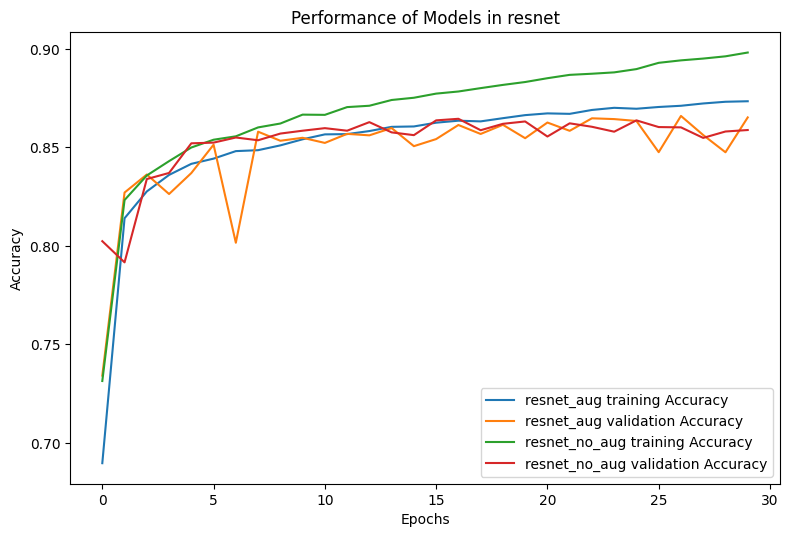

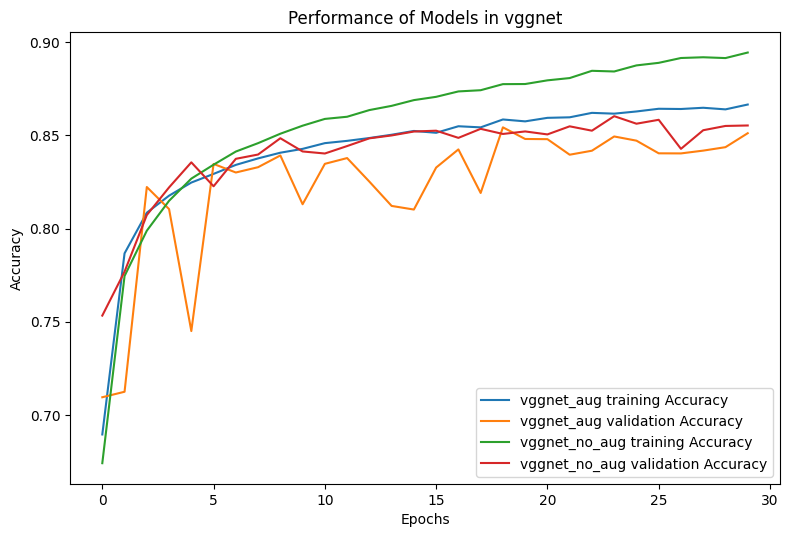

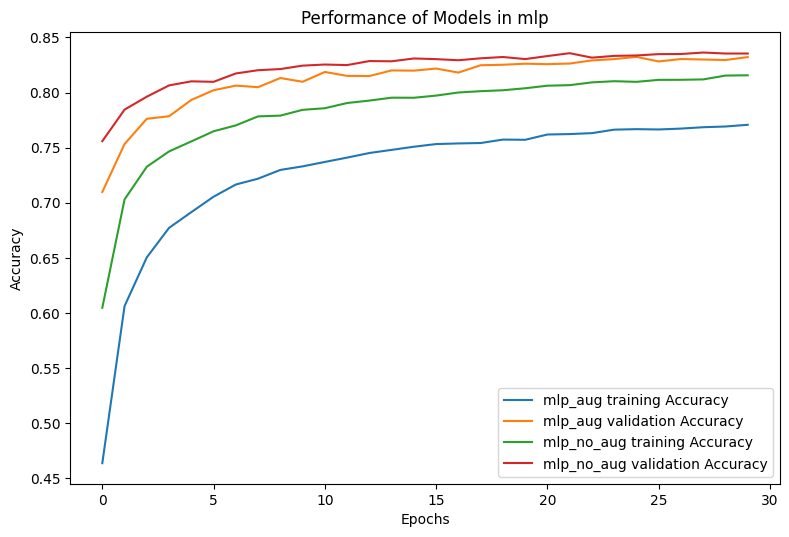

In [33]:
plot_model_accuracies(augmentation_test)

In [34]:
import pandas as pd
def summarize_model_accuracies(model_groups):
    # Create dictionaries to store accuracy statistics
    training_accuracies = {}
    validation_accuracies = {}

    # Loop over each group of models
    for group_name, models in model_groups.items():
        train_acc_list = []
        val_acc_list = []

        for model_name, (model, history) in models.items():
            history_data = history.history
            # Calculate statistics
            avg_train_acc = sum(history_data['accuracy']) / len(history_data['accuracy'])
            max_train_acc = max(history_data['accuracy'])

            avg_val_acc = sum(history_data['val_accuracy']) / len(history_data['val_accuracy'])
            max_val_acc = max(history_data['val_accuracy'])

            # Store results in dictionaries
            training_accuracies[model_name] = {'Average': avg_train_acc, 'Maximum': max_train_acc}
            validation_accuracies[model_name] = {'Average': avg_val_acc, 'Maximum': max_val_acc}

    # Convert dictionaries to DataFrames
    train_df = pd.DataFrame(training_accuracies).T
    val_df = pd.DataFrame(validation_accuracies).T

    # Create combined dataframe for easier comparison
    combined_df = pd.DataFrame({
        'Training Average': train_df['Average'],
        'Training Maximum': train_df['Maximum'],
        'Validation Average': val_df['Average'],
        'Validation Maximum': val_df['Maximum']
    })
    return combined_df


Tables for evaluation of all the accuracies

In [35]:
summarize_model_accuracies(hidden_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_hidden_size_16,0.812765,0.841100,0.842068,0.85950
resnet_hidden_size_32,0.834416,0.857862,0.846410,0.86125
resnet_hidden_size_64,0.844170,0.867238,0.849592,0.86410
vggnet_hidden_size_16,0.817253,0.854662,0.825370,0.85515
vggnet_hidden_size_32,0.815619,0.852713,0.815117,0.85175
vggnet_hidden_size_64,0.816753,0.853250,0.824842,0.85405
mlp_hidden_size_16,0.690300,0.733900,0.802115,0.82440
mlp_hidden_size_32,0.689951,0.731562,0.804030,0.82510
mlp_hidden_size_64,0.691621,0.734563,0.804428,0.82390


In [36]:
summarize_model_accuracies(dropout_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_dropout_rate_0.1,0.854952,0.877712,0.844967,0.86410
resnet_dropout_rate_0.2,0.849422,0.871500,0.846468,0.86175
resnet_dropout_rate_0.3,0.844131,0.867962,0.850445,0.86425
resnet_dropout_rate_0.4,0.837033,0.861825,0.850145,0.86490
vggnet_dropout_rate_0.1,0.816513,0.853037,0.829995,0.85135
vggnet_dropout_rate_0.2,0.819518,0.853850,0.826403,0.85355
vggnet_dropout_rate_0.3,0.818540,0.853513,0.827750,0.85330
vggnet_dropout_rate_0.4,0.818648,0.854813,0.827428,0.84960
mlp_dropout_rate_0.1,0.690361,0.732737,0.803818,0.82475
mlp_dropout_rate_0.2,0.691215,0.733525,0.804107,0.82430


In [37]:
summarize_model_accuracies(lr_test )

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_learning_rate_0.01,0.803891,0.835100,0.836780,0.85415
resnet_learning_rate_0.001,0.843860,0.866962,0.851290,0.86420
resnet_learning_rate_0.0001,0.831329,0.860762,0.846292,0.86150
vggnet_learning_rate_0.01,0.818102,0.855263,0.827768,0.85215
vggnet_learning_rate_0.001,0.817565,0.854250,0.830380,0.85435
vggnet_learning_rate_0.0001,0.816991,0.852950,0.825968,0.85360
mlp_learning_rate_0.01,0.690812,0.733050,0.803237,0.82325
mlp_learning_rate_0.001,0.690450,0.734012,0.803485,0.82180
mlp_learning_rate_0.0001,0.691306,0.734038,0.803902,0.82360


In [38]:
summarize_model_accuracies(regularization_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_regularization_rate_0.0,0.844047,0.866025,0.850912,0.86400
resnet_regularization_rate_0.01,0.816522,0.839575,0.832650,0.85380
resnet_regularization_rate_0.03,0.802785,0.828512,0.826627,0.85125
vggnet_regularization_rate_0.0,0.817485,0.853400,0.822013,0.85205
vggnet_regularization_rate_0.01,0.815523,0.854700,0.819802,0.85040
vggnet_regularization_rate_0.03,0.817524,0.853837,0.826395,0.85165
mlp_regularization_rate_0.0,0.690774,0.734637,0.804463,0.82465
mlp_regularization_rate_0.01,0.690168,0.733738,0.802838,0.82280
mlp_regularization_rate_0.03,0.691311,0.733763,0.803762,0.82495


In [39]:
summarize_model_accuracies(batch_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_batch_16,0.851546,0.870912,0.853963,0.86420
resnet_batch_32,0.852948,0.873700,0.853348,0.86750
resnet_batch_64,0.853251,0.873725,0.851943,0.86745
resnet_batch_128,0.852710,0.875238,0.849187,0.86620
vggnet_batch_16,0.821532,0.857400,0.829942,0.85535
vggnet_batch_32,0.831449,0.862850,0.836298,0.85735
vggnet_batch_64,0.837533,0.865038,0.820500,0.85385
vggnet_batch_128,0.842423,0.866325,0.823668,0.85250
mlp_batch_16,0.673942,0.713450,0.804400,0.82350
mlp_batch_32,0.707579,0.745238,0.811737,0.83095


In [40]:
summarize_model_accuracies(augmentation_test)

,Training Average,Training Maximum,Validation Average,Validation Maximum
resnet_aug,0.852426,0.873462,0.848038,0.86600
resnet_no_aug,0.868488,0.898200,0.853118,0.86455
vggnet_aug,0.842091,0.866600,0.823668,0.85435
vggnet_no_aug,0.856122,0.894525,0.840560,0.86035
mlp_aug,0.728443,0.770688,0.811513,0.83235
mlp_no_aug,0.783005,0.815638,0.822720,0.83630


In [41]:
# Summary the best hyperparameters for each model
best_hyperparams_resnet = {
    'hidden_size': 64,
    'dropout_rate': 0.4,
    'learning_rate': 0.001,
    'regularization_rate': 0.0,
    'activation': 'relu',
    'output_activation': 'softmax'
}

best_hyperparams_vggnet = {
    'hidden_size': 32,
    'dropout_rate': 0.2,
    'learning_rate': 0.01,
    'regularization_rate': 0.01,
    'activation': 'relu',
    'output_activation': 'softmax'
}

best_hyperparams_mlp = {
    'hidden_size' : 64,
    'dropout_rate' : 0.3,
    'learning_rate' : 1e-3,
    'regularization_rate' : 0.0,
    'activation' : 'relu',
    'output_activation' : 'softmax'
}

best_batch_size_resnet = 16
best_batch_size_vggnet = 32
best_batch_size_mlp = 128

Evaluation

In [42]:
# ResNet
train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size_resnet)

model_resnet_best = build_resnet(input_shape, num_classes, best_hyperparams_resnet)
history_resnet_best = model_resnet_best.fit(
    train_generator_no_aug,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 32s 9ms/step - accuracy: 0.5765 - loss: 1.5499 - val_accuracy: 0.7857 - val_loss: 0.6348
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8070 - loss: 0.5627 - val_accuracy: 0.8073 - val_loss: 0.5994
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8258 - loss: 0.4983 - val_accuracy: 0.8394 - val_loss: 0.4490
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8311 - loss: 0.4730 - val_accuracy: 0.8151 - val_loss: 0.5097
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8412 - loss: 0.4430 - val_accuracy: 0.8397 - val_loss: 0.4516
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8467 - loss: 0.4228 - val_accuracy: 0.8486 - val_loss: 0.4188
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8543 - loss: 0.4054 - val_accuracy: 0.8561 - val_loss: 0.3976
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 23s 9ms/step - accuracy: 0.8553 - loss: 0

In [43]:
# VGGNet
train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size_vggnet)

model_vggnet_best = build_vggnet(input_shape, num_classes, best_hyperparams_vggnet)
history_vggnet_best = model_vggnet_best.fit(
    train_generator_no_aug,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.5953 - loss: 1.4509 - val_accuracy: 0.7758 - val_loss: 0.7361
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.7714 - loss: 0.7047 - val_accuracy: 0.8007 - val_loss: 0.6077
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8014 - loss: 0.6018 - val_accuracy: 0.8077 - val_loss: 0.5387
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8136 - loss: 0.5496 - val_accuracy: 0.8296 - val_loss: 0.4992
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8273 - loss: 0.5075 - val_accuracy: 0.8374 - val_loss: 0.4907
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8348 - loss: 0.4822 - val_accuracy: 0.8378 - val_loss: 0.4720
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8424 - loss: 0.4520 - val_accuracy: 0.8372 - val_loss: 0.4672
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.8485 - loss: 0

In [44]:
# MLP
train_generator = train_datagen.flow(X_train, y_train, batch_size=best_batch_size_mlp)

model_mlp_best = build_mlp(input_shape, num_classes, best_hyperparams_mlp)
history_mlp_best = model_mlp_best.fit(
    train_generator_no_aug,
    epochs=epochs,
    validation_data=val_generator
)

Epoch 1/30


/home/epsilon/.local/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.5222 - loss: 1.8794 - val_accuracy: 0.7570 - val_loss: 0.7523
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6934 - loss: 1.0123 - val_accuracy: 0.7839 - val_loss: 0.6523
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7276 - loss: 0.8805 - val_accuracy: 0.7934 - val_loss: 0.6089
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7431 - loss: 0.8161 - val_accuracy: 0.8034 - val_loss: 0.5743
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7560 - loss: 0.7704 - val_accuracy: 0.8102 - val_loss: 0.5521
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7625 - loss: 0.7360 - val_accuracy: 0.8182 - val_loss: 0.5362
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7682 - loss: 0.7147 - val_accuracy: 0.8192 - val_loss: 0.5252
Epoch 8/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7753 - loss: 0.6900 - val_accurac

In [45]:
import time
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, X_test, y_test):
    start_time = time.time()

    y_pred_probs = model.predict(X_test)
    # Convert probabilities to class labels
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    runtime = time.time() - start_time

    cm = confusion_matrix(y_test, y_pred_classes)

    class_report = classification_report(y_test, y_pred_classes, output_dict=True)

    accuracy = class_report['accuracy']
    precision = class_report['macro avg']['precision']
    recall = class_report['macro avg']['recall']
    f1_score = class_report['macro avg']['f1-score']

    return (
      runtime,
      cm,
      class_report,
      accuracy,
      precision,
      recall,
      f1_score
    )

In [46]:
# Evaluate ResNet
runtime_resnet, cm_resnet, cr_resnet, accuracy_resnet, precision_resnet, recall_resnet, f1_resnet = evaluate_model(
    model_resnet_best, X_test, y_test)

print(f'Accuracy: {accuracy_resnet:.4f}')
print(f'Precision: {precision_resnet:.4f}')
print(f'Recall: {recall_resnet:.4f}')
print(f'F1 Score: {f1_resnet:.4f}')
print(f'Run time: {runtime_resnet}')
print(f'Confusion Matrix:\n{cm_resnet}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Accuracy: 0.8561
Precision: 0.7528
Recall: 0.7140
F1 Score: 0.7126
Run time: 3.319788932800293
Confusion Matrix:
[[693   0   0 ...   0   0   0]
 [  0 965   0 ...   0   0   0]
 [  0   1 985 ...   1   0   3]
 ...
 [  0   0   0 ... 100   1   0]
 [  0   0   0 ...   0  27   0]
 [  0   0  19 ...   1   0  41]]


/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [47]:
# Evaluate VGGNet
runtime_vggnet, cm_vggnet, cr_vggnet, accuracy_vggnet, precision_vggnet, recall_vggnet, f1_vggnet = evaluate_model(
    model_vggnet_best, X_test, y_test)

print(f'VGGNet Model:')
print(f'Accuracy: {accuracy_vggnet:.4f}')
print(f'Precision: {precision_vggnet:.4f}')
print(f'Recall: {recall_vggnet:.4f}')
print(f'F1 Score: {f1_vggnet:.4f}')
print(f'Run time: {runtime_vggnet}')
print(f'Confusion Matrix:\n{cm_vggnet}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
VGGNet Model:
Accuracy: 0.8510
Precision: 0.7312
Recall: 0.7265
F1 Score: 0.7213
Run time: 1.9745643138885498
Confusion Matrix:
[[735   0   0 ...   0   0   0]
 [  0 929   0 ...   0   0   0]
 [  0   0 913 ...   1   0  44]
 ...
 [  0   0   0 ...  54   0   0]
 [  0   0   0 ...   0  13   0]
 [  0   0  10 ...   0   0  46]]


/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [48]:
# Evaluate MLP
runtime_mlp, cm_mlp, cr_mlp, accuracy_mlp, precision_mlp, recall_mlp, f1_mlp = evaluate_model(
    model_mlp_best, X_test, y_test)

print(f'MLP Model:')
print(f'Accuracy: {accuracy_mlp:.4f}')
print(f'Precision: {precision_mlp:.4f}')
print(f'Recall: {recall_mlp:.4f}')
print(f'F1 Score: {f1_mlp:.4f}')
print(f'Run time: {runtime_mlp}')
print(f'Confusion Matrix:\n{cm_mlp}')

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 716us/step
MLP Model:
Accuracy: 0.8348
Precision: 0.7055
Recall: 0.6809
F1 Score: 0.6776
Run time: 0.9003012180328369
Confusion Matrix:
[[759   0   1 ...   0   0   0]
 [  0 964   3 ...   0   0   0]
 [  1   0 974 ...   0   0   4]
 ...
 [  0   1   0 ...  61   0   2]
 [  0   0   0 ...   0   5   0]
 [  0   0  19 ...   0   0  41]]


/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/epsilon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [60]:
import seaborn as sns

def plot_cm(cm):
    # Create a heatmap using seaborn
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap='Blues', fmt='g')  # annot=True to display numbers on the heatmap
    plt.title('Confusion Matrix Heatmap')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

In [ ]:
plot_cm(cm_resnet)
plot_cm(cm_vggnet)
plot_cm(cm_mlp)

In [58]:
def plot_incorrect_indices(model):
    predictions = np.argmax(model.predict(X_test), axis=1)
    
    incorrect_indices = np.where(predictions != y_test)[0]
    
    N = 10
    plt.figure(figsize=(20, 15))
    for i in range(N):
        index = incorrect_indices[i]
        plt.subplot(1, N, i+1)
        plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
        plt.title(f"True: {y_test[index]}, Pred: {predictions[index]}")
        plt.axis('off')
    plt.show()

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


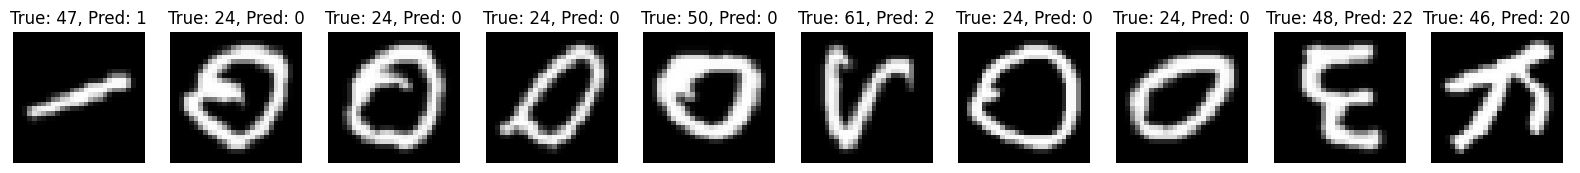

625/625 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step


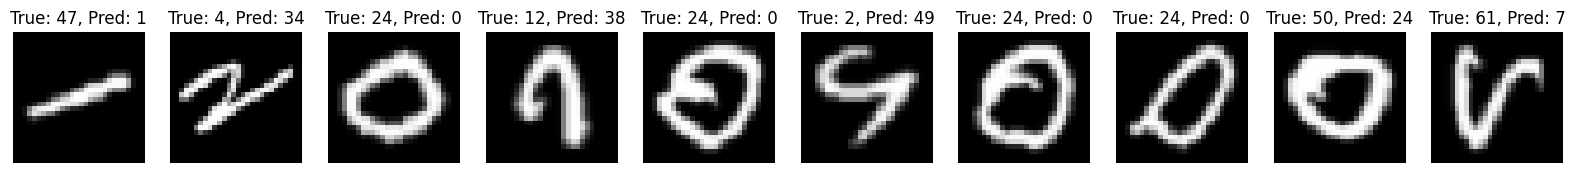

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step


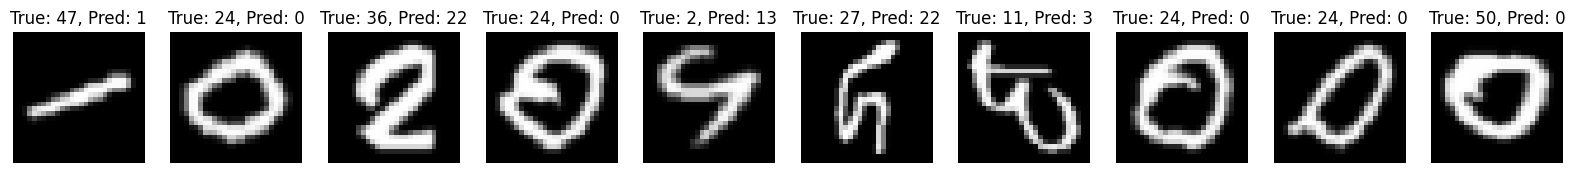

In [59]:
plot_incorrect_indices(model_resnet_best)
plot_incorrect_indices(model_vggnet_best)
plot_incorrect_indices(model_mlp_best)

Comparison

1. Model Performance Metrics Comparison

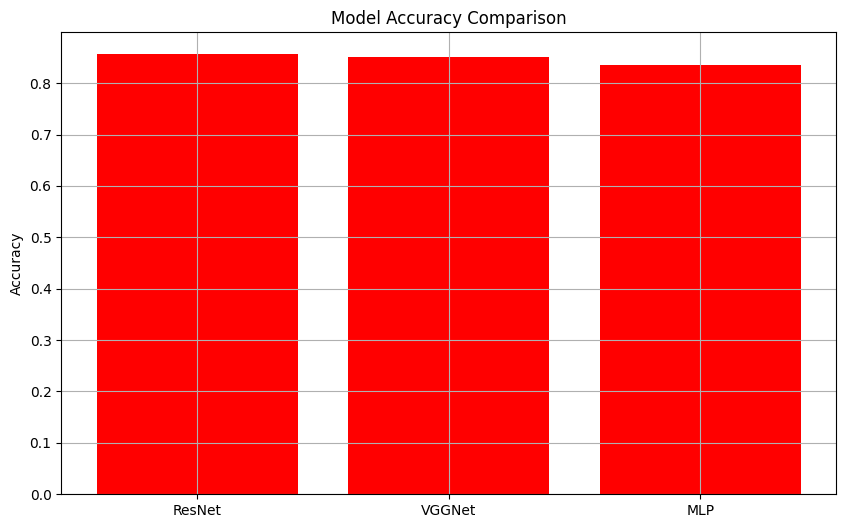

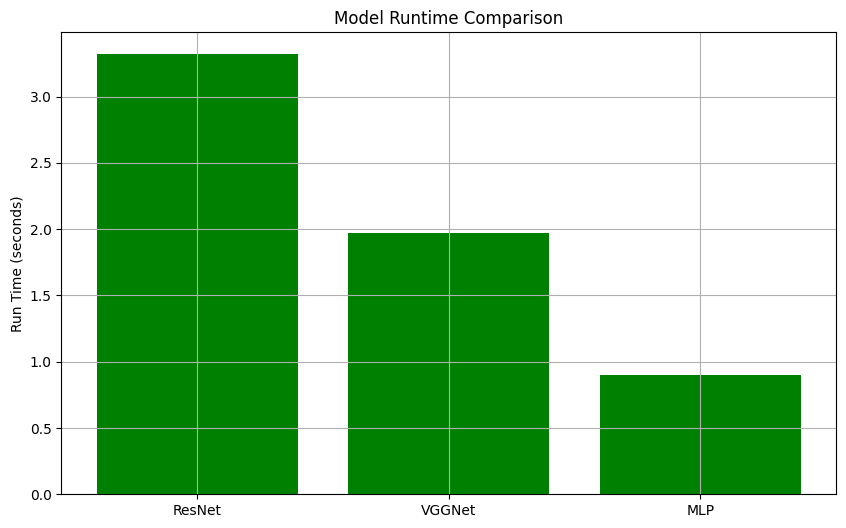

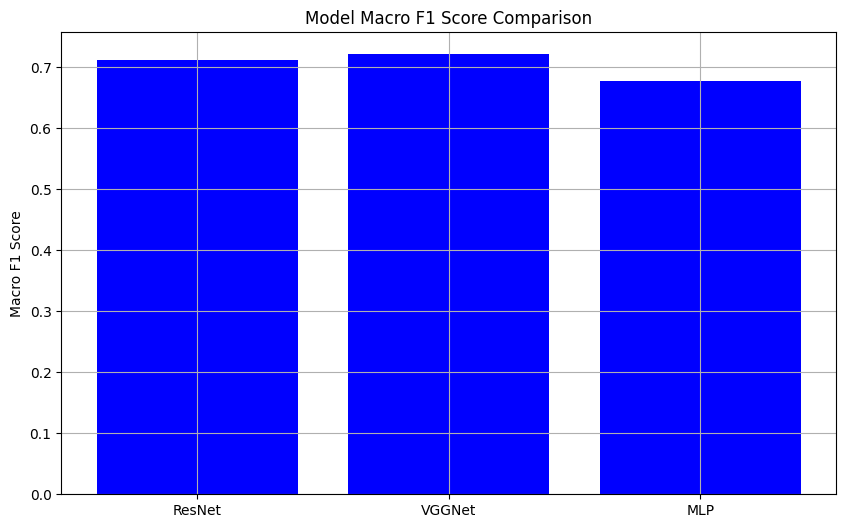

In [49]:
import pandas as pd

# Create a dataframe with performance metrics for all models
data = {
    'Model': ['ResNet', 'VGGNet', 'MLP'],
    'Accuracy': [accuracy_resnet, accuracy_vggnet, accuracy_mlp],
    'Run Time (s)': [runtime_resnet, runtime_vggnet, runtime_mlp],
    'Macro F1 Score': [f1_resnet, f1_vggnet, f1_mlp]
}

# Convert the data to a DataFrame
df = pd.DataFrame(data)

# Plot Accuracy comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Accuracy'], color='red')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.grid(True)
plt.show()

# Plot Runtime comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Run Time (s)'], color='green')
plt.ylabel('Run Time (seconds)')
plt.title('Model Runtime Comparison')
plt.grid(True)
plt.show()

# Plot F1 Score comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Model'], df['Macro F1 Score'], color='blue')
plt.ylabel('Macro F1 Score')
plt.title('Model Macro F1 Score Comparison')
plt.grid(True)
plt.show()

2.Overfitting Evaluation Across Models

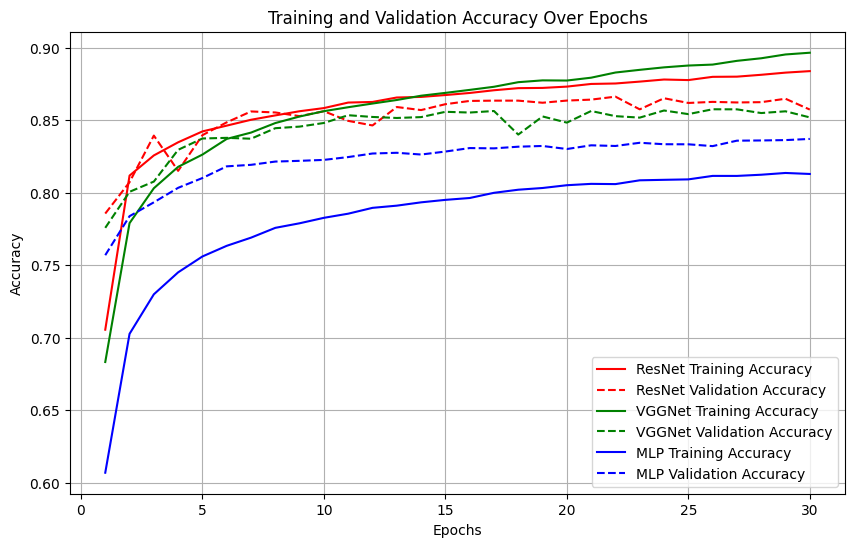

In [50]:
resnet_train_acc = history_resnet_best.history['accuracy']
resnet_val_acc = history_resnet_best.history['val_accuracy']
epochs_resnet = range(1, len(resnet_train_acc) + 1)  # Epochs for ResNet

vggnet_train_acc = history_vggnet_best.history['accuracy']
vggnet_val_acc = history_vggnet_best.history['val_accuracy']
epochs_vggnet = range(1, len(vggnet_train_acc) + 1)  # Epochs for VGGNet

mlp_train_acc = history_mlp_best.history['accuracy']
mlp_val_acc = history_mlp_best.history['val_accuracy']
epochs_mlp = range(1, len(mlp_train_acc) + 1)  # Epochs for MLP

plt.figure(figsize=(10, 6))

plt.plot(epochs_resnet, resnet_train_acc, 'r', label='ResNet Training Accuracy')
plt.plot(epochs_resnet, resnet_val_acc, 'r--', label='ResNet Validation Accuracy')

plt.plot(epochs_vggnet, vggnet_train_acc, 'g', label='VGGNet Training Accuracy')
plt.plot(epochs_vggnet, vggnet_val_acc, 'g--', label='VGGNet Validation Accuracy')

plt.plot(epochs_mlp, mlp_train_acc, 'b', label='MLP Training Accuracy') # Use epochs_mlp for MLP
plt.plot(epochs_mlp, mlp_val_acc, 'b--', label='MLP Validation Accuracy') # Use epochs_mlp for MLP


plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)